In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, auc, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models


In [10]:
class AutismDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []

        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                label = 0 if category == 'TC' else 1
                for participant_folder in os.listdir(category_path):
                    participant_path = os.path.join(category_path, participant_folder)
                    if os.path.isdir(participant_path):
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                                img_full_path = os.path.join(participant_path, img_name)
                                self.filepaths.append(img_full_path)
                                self.labels.append(label)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_path = "./Dataset_Split4/Augmented_Train"
val_path = "./Dataset_Split4/Validation"
test_path = "./Dataset_Split4/Test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = AutismDataset(train_path, transform=transform)
val_dataset = AutismDataset(val_path, transform=transform)
test_dataset = AutismDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    num_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_samples

    mean /= num_samples
    std /= num_samples
    return mean, std

train_mean, train_std = calculate_mean_std(train_loader)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

train_dataset = AutismDataset(train_path, transform=transform)
val_dataset = AutismDataset(val_path, transform=transform)
test_dataset = AutismDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = models.densenet121(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.model.features.denseblock4.parameters():
            param.requires_grad = True

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
        self.model.classifier.apply(self.initialize_weights)

    def forward(self, x):
        output = self.model(x)
        if self.model.classifier[-1].out_features == 1:
            output = torch.sigmoid(output)
        return output

    @staticmethod
    def initialize_weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

In [12]:
model = CNNModel().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000003, weight_decay=1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = np.inf

for epoch in range(25):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float32).view(-1)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float32).view(-1)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "best_model_dense.pth")

    scheduler.step(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1], Train Loss: 0.8712, Val Loss: 0.6505, Train Acc: 0.4955, Val Acc: 0.6778
Epoch [2], Train Loss: 0.7818, Val Loss: 0.5925, Train Acc: 0.5404, Val Acc: 0.7111
Epoch [3], Train Loss: 0.7165, Val Loss: 0.5539, Train Acc: 0.5958, Val Acc: 0.7556
Epoch [4], Train Loss: 0.6967, Val Loss: 0.5365, Train Acc: 0.6062, Val Acc: 0.7889
Epoch [5], Train Loss: 0.6790, Val Loss: 0.5351, Train Acc: 0.6281, Val Acc: 0.7556
Epoch [6], Train Loss: 0.6688, Val Loss: 0.5161, Train Acc: 0.6340, Val Acc: 0.7889
Epoch [7], Train Loss: 0.6411, Val Loss: 0.5089, Train Acc: 0.6553, Val Acc: 0.7556
Epoch [8], Train Loss: 0.6158, Val Loss: 0.4890, Train Acc: 0.6733, Val Acc: 0.7667
Epoch [9], Train Loss: 0.6224, Val Loss: 0.4820, Train Acc: 0.6705, Val Acc: 0.7778
Epoch [10], Train Loss: 0.5990, Val Loss: 0.5103, Train Acc: 0.6823, Val Acc: 0.7556
Epoch [11], Train Loss: 0.5940, Val Loss: 0.4992, Train Acc: 0.6893, Val Acc: 0.7556
Epoch [12], Train Loss: 0.5683, Val Loss: 0.5040, Train Acc: 0.7118, Val A

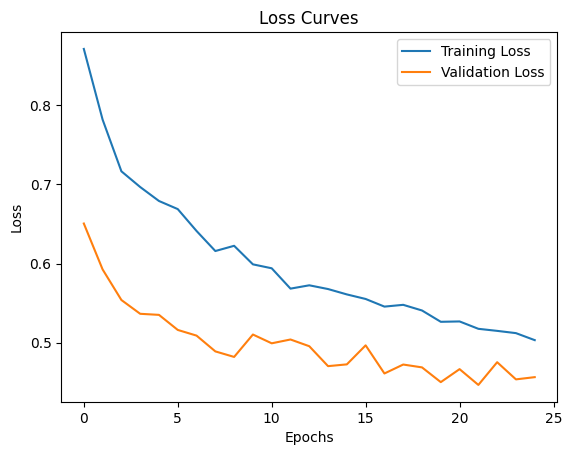

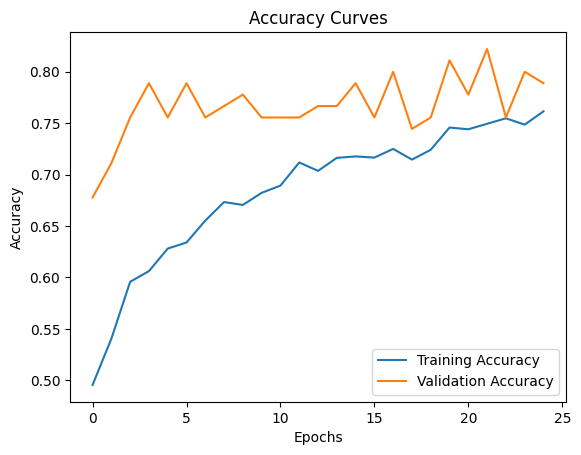

In [15]:
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_521194/3451518274.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/

Test Loss: 0.4919
Test Accuracy: 0.7921
Test AUC: 0.8342
Recall: 0.6923


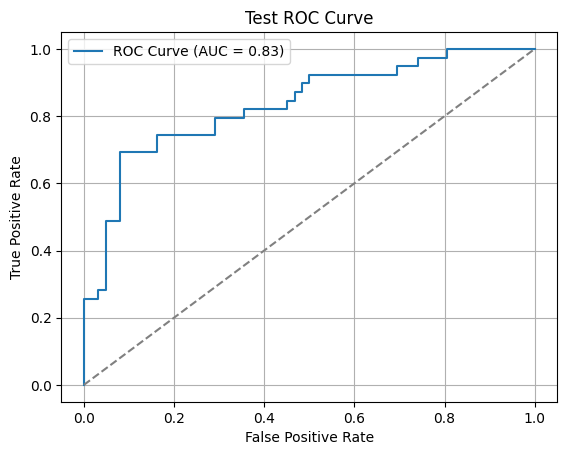

In [16]:
best_model = CNNModel().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
best_model.load_state_dict(torch.load("best_model_dense.pth"))
best_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
test_preds, test_true = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float32).view(-1)
        outputs = best_model(inputs).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        test_preds.extend(outputs.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

fpr, tpr, thresholds = roc_curve(test_true, test_preds)
test_auc = auc(fpr, tpr)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {correct_test / total_test:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Recall: {recall_score(test_true, (np.array(test_preds) > 0.5).astype(int)):.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [17]:
class AutismDataset1(Dataset):
    def __init__(self, root_dir, type='ind', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.type = type    
        self.data = []
        self.images_all = []
        self.labels_all = []
        self.labels = []
        self.participant_id = []
        for category in os.listdir(root_dir):
            category_dir = os.path.join(root_dir, category)
            if os.path.isdir(category_dir):
                for participant_folder in os.listdir(category_dir):
                    participant_path = os.path.join(category_dir, participant_folder)
                    if os.path.isdir(participant_path):
                        image_paths = []
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                                img_full_path = os.path.join(participant_path, img_name)
                                if os.path.isfile(img_full_path):
                                    image_paths.append(img_full_path)
                                    self.images_all.append(img_full_path)
                                    self.labels_all.append(0 if category == 'TC' else 1)
                        if image_paths:
                            self.data.append(image_paths)
                            label = 0 if category == 'TC' else 1
                            self.labels.append(label)
                            self.participant_id.append(participant_folder)

    def __len__(self):
        if self.type == 'img':
            return len(self.images_all)
        elif self.type == 'ind':
            return len(self.data)
    
    def __getitem__(self, idx):
        if self.type == 'img':
            image = self.images_all[idx]
            processed_image = self.transform(Image.open(image).convert("RGB"))
            label = self.labels_all[idx]
            return processed_image, label
        elif self.type == 'ind':
            images = self.data[idx]
            label = self.labels[idx]
            processed_images = [self.transform(Image.open(img).convert("RGB")) for img in images]
            return torch.stack(processed_images), label, self.participant_id[idx]
        
        
test_dir = "./Dataset_Split4/Test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

test_dataset = AutismDataset1(test_dir, type='ind', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

best_model = CNNModel().to(device)
best_model.load_state_dict(torch.load("best_model_dense.pth"))
best_model.eval()
individual_results = []

with torch.no_grad():
    for images, labels, participant_ids in test_loader:
        labels = labels.to(device)
        for i, participant_images in enumerate(images):
            participant_id = participant_ids[i]
            lbl = labels[i].item()
            preds = []

            for img in participant_images:
                img = img.unsqueeze(0).to(device)
                output = best_model(img)
                pred = (output > 0.5).int().item()
                preds.append(pred)

            positive_preds = sum(preds)
            total_images = len(preds)
            individual_accuracy = positive_preds / total_images
            prediction = 1 if individual_accuracy > 0.5 else 0

            individual_results.append({
                 "Category": "TS" if lbl == 1 else "TC",
                "Participant": participant_id,
                "Prediction": "Autistic" if prediction == 1 else "Not Autistic",
                "Probability": individual_accuracy
            })
    
results_df = pd.DataFrame(individual_results)

print(results_df)

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_521194/1694113304.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

  Category Participant    Prediction  Probability
0       TC          49  Not Autistic     0.250000
1       TC          31  Not Autistic     0.000000
2       TC          33  Not Autistic     0.157895
3       TC          58  Not Autistic     0.130435
4       TC          48  Not Autistic     0.125000
5       TS           9      Autistic     1.000000
6       TS           4  Not Autistic     0.428571
7       TS          19      Autistic     0.812500
8       TS           8      Autistic     0.800000
